In [6]:
%load_ext rpy2.ipython

In [2]:
from IPython.display import FileLink

In [7]:
%%R
library(ggplot2)
library(plyr); library(dplyr); library(tidyr)
library(DESeq2)
library(phyloseq)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.

In [4]:
%%R
physeq = import_biom("../data/otu_table_wtax.biom")
sample.data = import_qiime_sample_data("../data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)

In [13]:
%%R
FDR = 0.10

df.rspndrs = read.csv("../data/l2fc_table.csv") %>%
    group_by(OTU, Treatment) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by() %>%
    spread(Treatment, minP)

rspnse = function(x) {
    ifelse(sum(x <= FDR, na.rm = TRUE) == 2, "Both", ifelse(!is.na(x[1]), "Cellulose", "Xylose"))
}

df.rspndrs$rspnse = apply(df.rspndrs[,c("13CCPS", "13CXPS")], 1, rspnse)

df.rspndrs = df.rspndrs %>% select(OTU, rspnse)

df.rspndrs

Source: local data frame [104 x 2]

        OTU    rspnse
1   OTU.100 Cellulose
2  OTU.1023 Cellulose
3  OTU.1040    Xylose
4  OTU.1065 Cellulose
5  OTU.1069    Xylose
6   OTU.107    Xylose
7  OTU.1087 Cellulose
8  OTU.1094 Cellulose
9    OTU.11      Both
10  OTU.114 Cellulose
..      ...       ...


In [14]:
%%R
p.bulk = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS","13CXPS"))&
                               (row.names(physeq.md) %in% grep("bulk", row.names(physeq.md), value=TRUE)), physeq) 

dds = phyloseq_to_deseq2(p.bulk, ~factor(Day))
dds = DESeq(dds)
r = results(dds, cooksCutoff = FALSE)
r$OTU = rownames(r)
r = data.frame(r)

TT = data.frame(tax_table(p.bulk))
TT$OTU = rownames(TT)

r = left_join(r, TT)

converting counts to integer mode
the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
NOTE: fitType='parametric', but the dispersion trend was not well captured by the
  function: y = a/x + b, and a local regression fit was automatically substituted.
  specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
Joining by: "OTU"


In [34]:
%%R
l2fc.time = r %>% 
    filter(baseMean > 0)

write.csv(l2fc.time, "../data/l2fcWtime_table.csv", row.names = FALSE)

In [8]:
%%R
l2fc.time = read.csv("../data/l2fcWtime_table.csv")
r = l2fc.time

In [9]:
!head ../data/l2fcWtime_table.csv | cut -c 1-60

"OTU","baseMean","log2FoldChange","lfcSE","stat","pvalue","p
"OTU.1968",0.195219016871707,-0.482227622299288,0.8510638610
"OTU.1965",0.059103174511118,-0.182065142523598,0.8054150766
"OTU.1966",0.0912009375825274,-0.299538063590862,0.804337615
"OTU.1961",0.1342113474502,-0.319013960935569,0.808068551662
"OTU.1963",0.288185551430552,0.00607298899630715,0.952552678
"OTU.5065",7.11436654577397,-1.53583741003357,0.655068017750
"OTU.5060",0.767261817679292,1.16992876463179,0.972017805211
"OTU.832",0.763016131305235,-0.384591127502355,0.99994496651
"OTU.4337",0.0676479141219701,-0.203842411277988,0.805202266


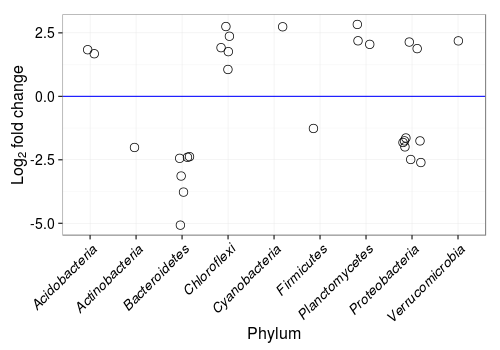

In [10]:
%%R -w 500 -h 350
FDR = 0.10

d = r %>%
    arrange(desc(abs(log2FoldChange))) %>%
    select(OTU, Rank2, log2FoldChange, padj) %>%
    filter(padj <= FDR)

p = ggplot(d, aes(x = Rank2, y = log2FoldChange))

p = p + geom_point(size = 4, shape = 21, position = position_jitter(w = 0.20))

p = p + geom_hline(yintercept = 0, color = "blue")

p = p + theme_bw()

p = p + labs(x = "Phylum", y = expression(paste(Log[2]," fold change",sep="")))

p = p + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14, face = "italic"),
              axis.text.y = element_text(size = 14), 
              axis.title = element_text(size = 16))

p

Joining by: "OTU"


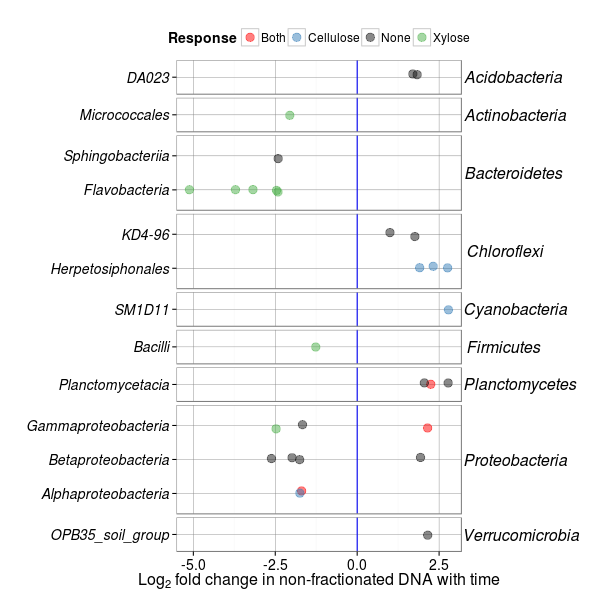

In [18]:
%%R -h 600 -w 600

colours = c("red", "#377eb8", "#151515", "#4daf4a")

FDR = 0.10 

d = r %>%
    arrange(desc(abs(log2FoldChange))) %>%
    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj) %>%
    filter(padj <= FDR)

d = left_join(d, df.rspndrs)
d$rspnse[is.na(d$rspnse)] = "None"

p = ggplot(d, aes(y = Rank3, x = log2FoldChange, color = rspnse))

p = p + geom_point(size = 6, shape = 20, alpha = 0.5, position = position_jitter(h = 0.10))

p = p + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p = p + geom_vline(xintercept = 0, color = "blue")

p = p + scale_color_manual(values = colours, na.value = "black")

p = p + theme_bw()

p = p + labs(x = expression(paste(Log[2]," fold change in non-fractionated DNA with time",sep="")), color = "Response", y = "")

p = p + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p.fc = p

p.fc

In [19]:
%%R
ggsave("figs/l2fc_time.pdf", p.fc, h = 8.5, w = 8)

In [25]:
FileLink("figs/l2fc_time.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/l2fc_time.pdf

In [39]:
%%R
r %>% filter(padj <= FDR) %>% select(OTU, Rank2, Rank3, log2FoldChange)

        OTU           Rank2               Rank3 log2FoldChange
1   OTU.253   Acidobacteria               DA023       1.836173
2   OTU.120   Cyanobacteria              SM1D11       2.740001
3   OTU.121   Bacteroidetes    Sphingobacteriia      -2.375461
4  OTU.1701  Proteobacteria  Betaproteobacteria      -1.989491
5     OTU.8      Firmicutes             Bacilli      -1.265400
6     OTU.2  Proteobacteria Gammaproteobacteria      -1.640276
7     OTU.6  Proteobacteria Gammaproteobacteria       2.139360
8   OTU.352  Proteobacteria  Betaproteobacteria       1.879331
9    OTU.48  Proteobacteria Gammaproteobacteria      -2.486182
10 OTU.2358     Chloroflexi              KD4-96       1.760569
11  OTU.313  Planctomycetes    Planctomycetacia       2.833689
12   OTU.64     Chloroflexi   Herpetosiphonales       1.917427
13   OTU.67   Acidobacteria               DA023       1.678367
14   OTU.28  Proteobacteria Alphaproteobacteria      -1.753622
15   OTU.26  Proteobacteria  Betaproteobacteria      -1

In [43]:
%%R
mdf = psmelt(p.bulk)
d = mdf %>%
    group_by(Rank3, Sample) %>%
    summarize(Abundance = sum(Abundance))

d = data.frame(d)
d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unassigned"

d = d %>% spread(Sample, Abundance)
rownames(d) = d$Rank3
d$Rank3 = NULL
count.data = as.matrix(d)

col.data = data.frame(sample_data(p.bulk))
col.data$Day.f = factor(col.data$Day)

count.data = count.data[,rownames(col.data),drop=FALSE]

dds = DESeqDataSetFromMatrix(count.data, col.data, ~Day.f)
dds = DESeq(dds)
r = results(dds, cooksCutoff = FALSE, independentFiltering = FALSE)
r$Rank3 = rownames(r)

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


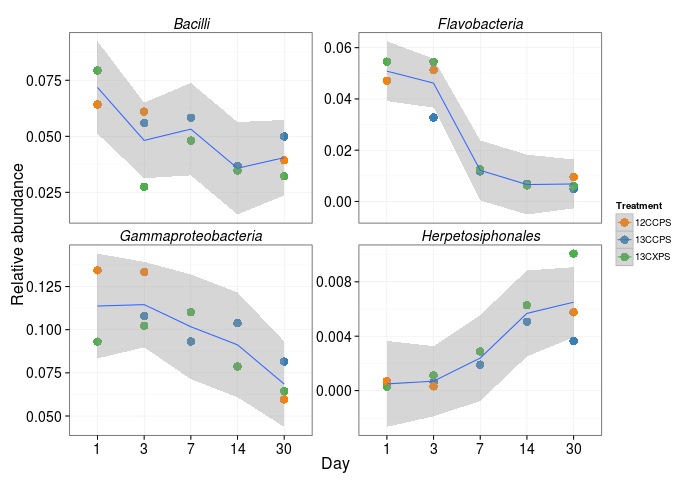

In [46]:
%%R -w 700
colours = c("#ff7f00", "#377eb8", "#4daf4a")

sig = data.frame(r) %>% arrange(padj) %>% select(Rank3, padj, log2FoldChange) %>% filter(padj <= FDR)

d = mdf %>%
    group_by(Rank3, Sample, Day, Treatment) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Sample) %>%
    mutate(Relative.abundance = Abundance / sum(Abundance)) %>%
    filter(Rank3 %in% sig$Rank3)

p = ggplot(d, aes(x = factor(Day), y = Relative.abundance, color = Treatment))

p = p + facet_wrap(~Rank3, scales = "free_y")

p = p + geom_point(size = 4)

p = p + stat_smooth(method = "loess", aes(group = 1))

p = p + labs(x = "Day", y = "Relative abundance")

p = p + scale_color_manual(values = colours)

p = p + theme_bw()

p = p + theme(strip.text = element_text(size = 14, face = "italic"),
              strip.background = element_blank(),
              axis.text = element_text(size = 14),
              axis.title = element_text(size = 16))

p.class = p

p.class

In [47]:
%%R
ggsave("figs/abndVtime_class.pdf", p.class, h = 6, w = 8)

In [48]:
FileLink("figs/abndVtime_class.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/abndVtime_class.pdf